In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

warnings.simplefilter(action='ignore', category=FutureWarning)
import sys

sys.path.append('../')

import optuna

from straindesignxai.main import DataLoader

RESPONSE_VARS = ['Limonene']

INPUT_VARS = ['ATOB_ECOLI','ERG8_YEAST','IDI_ECOLI',
                   'KIME_YEAST','MVD1_YEAST','Q40322_MENSP',
                   'Q8LKJ3_ABIGR','Q9FD86_STAAU','Q9FD87_STAAU']

DBTL_A = ['2X.Mh', 'B.Lm', '2X.Ll', 'A.Mm', 'B.Ll', 'A.Mh', '2X.Lm',
       'A.Hl', '2X.Hh', 'B.Ml', 'B.Mm', '2X.Lh', 'B.Mh', '2X.Hl', 'B.Hl',
       '2X.Ml', 'B.Hm', 'B.Lh', 'B.Hh', 'A.Ll', 'A.Hm', '2X.Mm', 'A.Hh',
       'A.Ml', 'A.Lm',  'A.Lh', '2X.Hm']

DBTL_B = ['BL.Mm', 'BL.Mh', 'BL.Ml']

PATH = '../data/preprocessed_Limonene_data.csv'

In [2]:
dl = DataLoader(PATH, INPUT_VARS, RESPONSE_VARS)
# Keep only DBTL_A indexes
# dl.df = dl.df[dl.df.index.isin(DBTL_A)]
# dl.X = dl.df[INPUT_VARS]
# dl.y = dl.df[RESPONSE_VARS]
print(f'New data shape: {dl.df.shape}')
dl.train_xgb(n_iter=300)

Dataset size: (30, 10)
New data shape: (30, 10)


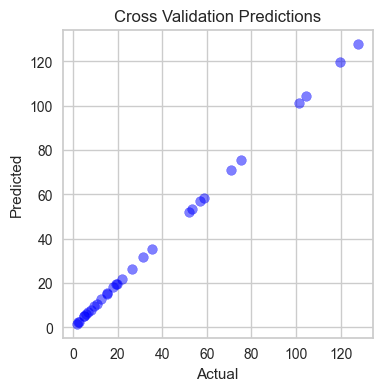

In [3]:
dl.plot_R2()

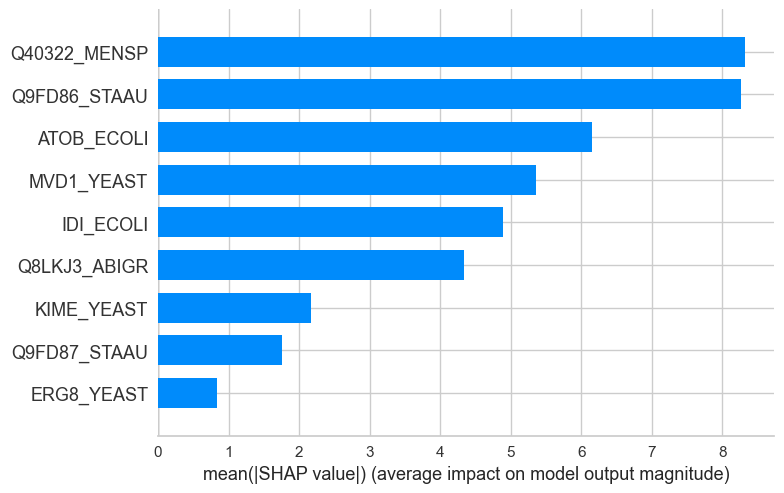

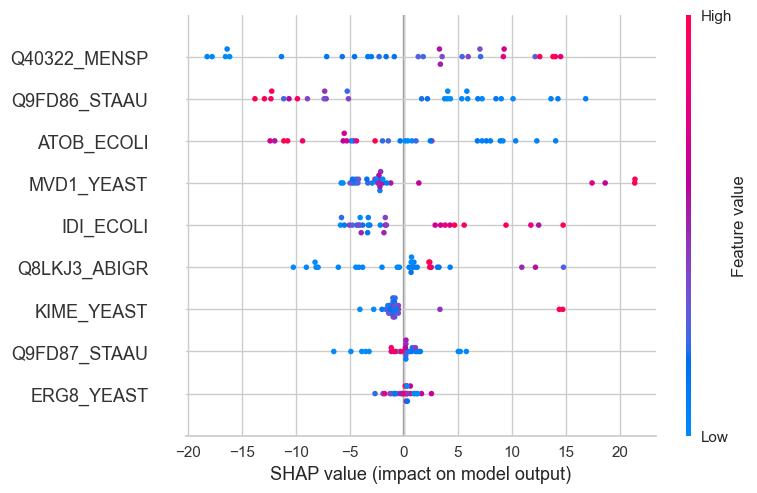

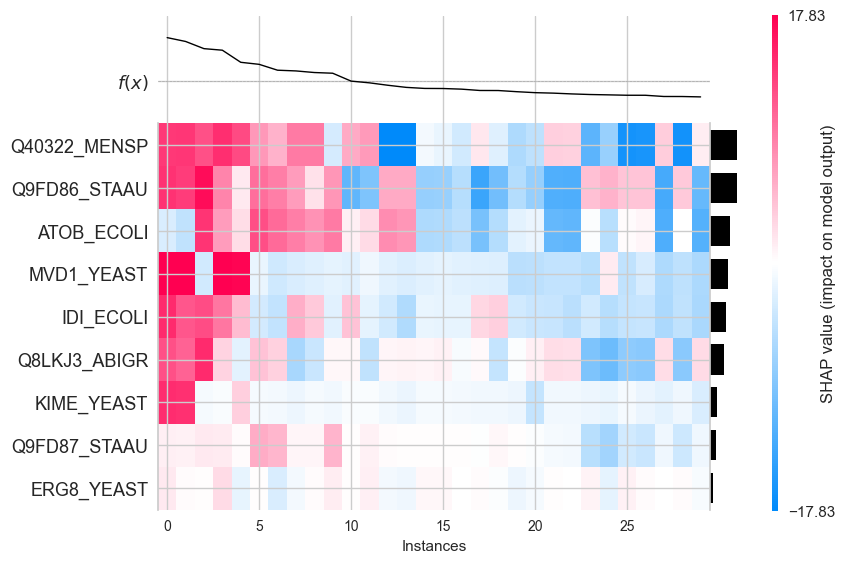

In [4]:
dl.get_shap_values()

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than

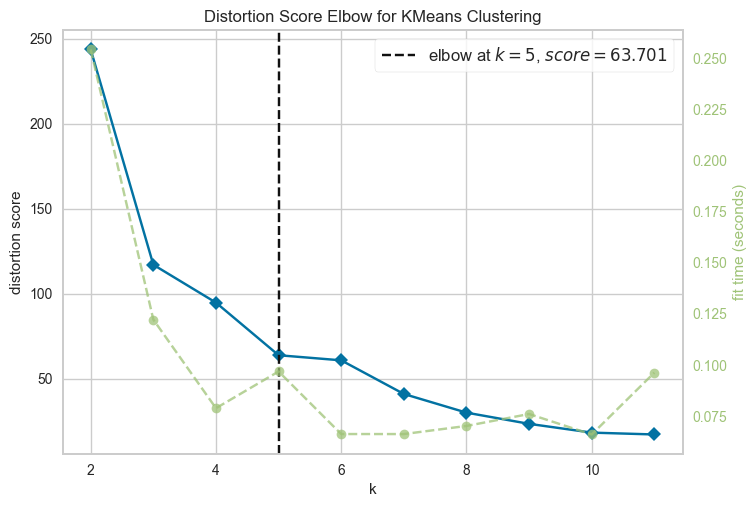

Optimal number of clusters: 5


KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


In [5]:
dl.supervised_clustering()

In [6]:
dl.study_clusters()

Number of elements in each cluster: 
0    13
3     7
4     5
2     4
1     1
Name: cluster, dtype: int64


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
cluster,,,,,,,,,,
0,0.915223,0.774985,1.556192,0.278646,1.334969,4.432262,1.228546,2.276677,2.919338,15.398056
1,0.165400,0.440700,1.852700,0.255500,1.129000,4.531700,0.892200,0.278600,0.375600,104.536550
2,0.919183,0.775637,2.700712,0.812240,2.862687,11.337685,1.057567,0.485930,0.588510,106.101655
3,0.094546,0.294600,1.101449,0.217171,1.094001,2.184680,0.164124,0.100903,0.145919,10.550626
4,0.145600,0.487060,1.648760,0.220260,1.158840,5.695200,0.322860,0.310540,0.361100,58.459542


In [9]:
dl.df[dl.df['cluster'].isin([1,2])]

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene,cluster
BL.Mm,1.25540,0.58985,2.29065,1.04860,3.19300,11.31405,1.63235,0.25975,0.41045,119.81367,2
BL.Mh,1.95983,0.78130,2.59550,1.42496,4.10495,13.59919,1.86762,0.39057,0.65389,127.99494,2
2X.Mm,0.22310,0.79010,2.73540,0.37440,1.95920,9.23380,0.43350,0.51180,0.54090,101.20540,2
2X.Mh,0.23840,0.94130,3.18130,0.40100,2.19360,11.20370,0.29680,0.78160,0.74880,75.39261,2
B.Ml,0.16540,0.44070,1.85270,0.25550,1.12900,4.53170,0.89220,0.27860,0.37560,104.53655,1


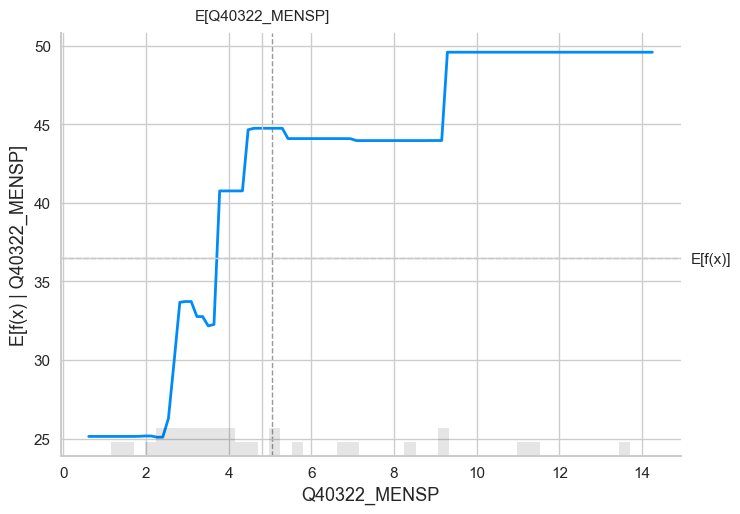

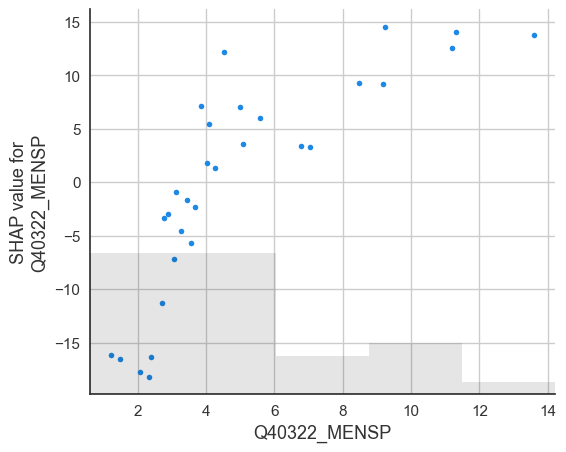

In [16]:
dl.pdplot('Q40322_MENSP')
dl.shap_scatter('Q40322_MENSP')